# Build a SeqData

In [1]:
# Imports
import os
import numpy as np
import seqdata as sd

import pyBigWig
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
def plot_tracks(tracks, interval, height=1.5, colors=None):
  _, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  if not isinstance(axes, np.ndarray):
    axes = [axes]
  for ax, (title, y) in zip(axes, tracks.items()):
    if colors is not None:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y, color=colors[title])
    else:
      ax.fill_between(np.linspace(interval["start"], interval["end"], num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(f"{interval['chrom']}:{interval['start']}-{interval['end']}")
  plt.tight_layout()

In [ ]:
# Paths
data_dir = "/cellar/users/aklie/data/datasets/K562_STARR-seq/data"
fasta = "/cellar/users/aklie/data/ref/genomes/hg38/hg38.fa"

In [27]:
# normalized bigwigs
rep1 = pyBigWig.open(str("/cellar/users/aklie/data/datasets/K562_STARR-seq/data/ENCSR926NDZ_K562_STARR-seq_rep1.bw"))
rep2 = pyBigWig.open(str("/cellar/users/aklie/data/datasets/K562_STARR-seq/data/ENCSR926NDZ_K562_STARR-seq_rep2.bw"))
rep3 = pyBigWig.open(str("/cellar/users/aklie/data/datasets/K562_STARR-seq/data/ENCSR926NDZ_K562_STARR-seq_rep3.bw"))

In [28]:
# peaks
peaks = pd.read_csv("/cellar/users/aklie/data/datasets/K562_STARR-seq/data/ENCSR926NDZ_K562_STARR-seq_peaks.bed.gz", sep="\t", header=None)
peaks

,0,1,2,3,4,5,6,7,8,9,10
0,chr1,605238,605765,chr1:605238-605765,100,.,56,-35,20,3.53,2.39
1,chr1,778388,779038,chr1:778388-779038,100,.,581,0,581,5.19,3.94
2,chr1,827188,827788,chr1:827188-827788,100,.,220,-47,173,3.05,2.40
3,chr1,841688,841738,chr1:841688-841738,100,.,59,-15,44,3.04,1.79
4,chr1,909828,909888,chr1:909828-909888,100,.,-36,-29,-66,2.43,2.03
...,...,...,...,...,...,...,...,...,...,...,...
60727,chrX,155881006,155881456,chrX:155881006-155881456,100,.,171,-12,158,2.90,2.05
60728,chrX,155881506,155881806,chrX:155881506-155881806,100,.,98,-8,89,3.13,2.05
60729,chrX,155893606,155893756,chrX:155893606-155893756,100,.,153,12,166,2.84,2.07
60730,chrX,156021706,156021806,chrX:156021706-156021806,100,.,-51,-29,-81,2.31,1.86


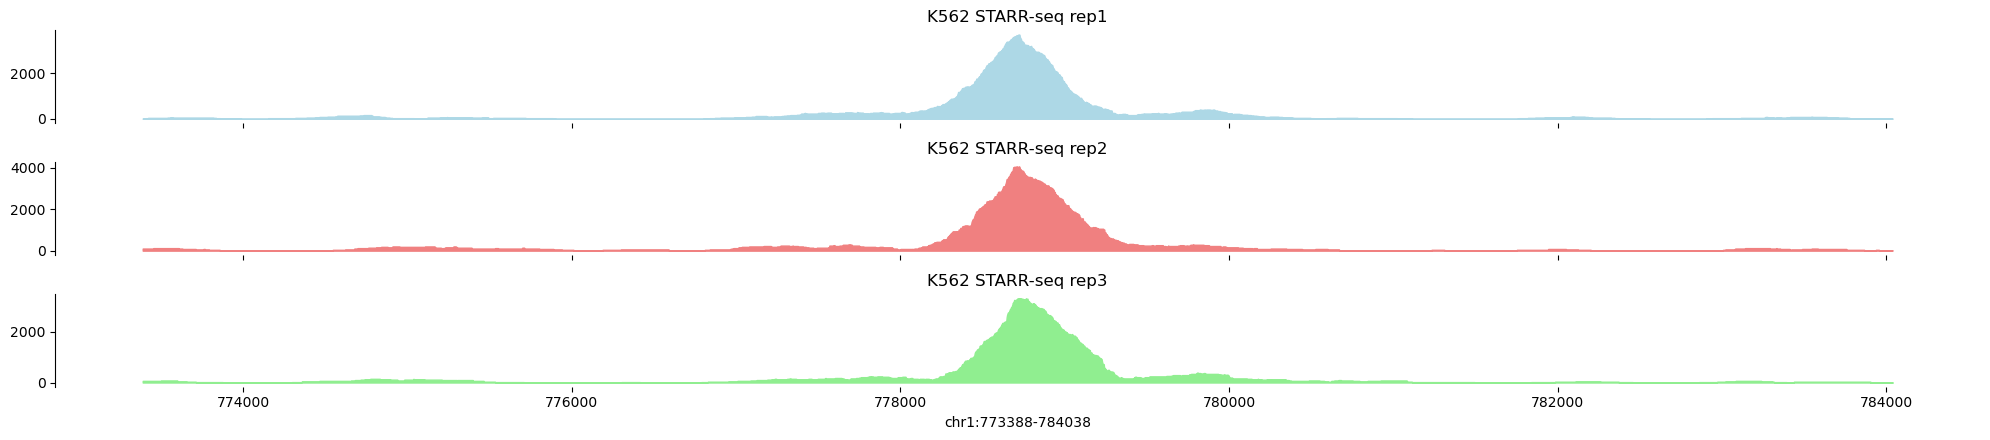

In [34]:
seq_num = 1
chrom = peaks[0][seq_num]
chromStart = peaks[1][seq_num] - 5000
chromEnd = peaks[2][seq_num] + 5000
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)
tracks = {
    "K562 STARR-seq rep1": rep1.values(chrom, chromStart, chromEnd),
    "K562 STARR-seq rep2": rep2.values(chrom, chromStart, chromEnd),
    "K562 STARR-seq rep3": rep3.values(chrom, chromStart, chromEnd)
} 
colors={
    "K562 STARR-seq rep1": "lightblue",
    "K562 STARR-seq rep2": "lightcoral",
    "K562 STARR-seq rep3": "lightgreen"
}

# Plot tracks
plot_tracks(
    tracks=tracks,
    interval=interval,
    colors=colors
)

In [3]:
# TODO: change to your paths
peaks = os.path.join(data_dir, "peaks.bed")
signals = [
    os.path.join(data_dir, "plus.bw"),
    os.path.join(data_dir, "minus.bw")
]
sample_names = ['signal+', 'signal-']
peaks, signals

('/cellar/users/aklie/data/datasets/K562_CTCF-ChIP-seq/data/peaks.bed',
 ['/cellar/users/aklie/data/datasets/K562_CTCF-ChIP-seq/data/plus.bw',
  '/cellar/users/aklie/data/datasets/K562_CTCF-ChIP-seq/data/minus.bw'])

In [4]:
# Make output directory if doesn't exist
out = os.path.join(data_dir, "K562_CTCF-ChIP-seq.zarr")
out

'/cellar/users/aklie/data/datasets/K562_CTCF-ChIP-seq/data/K562_CTCF-ChIP-seq.zarr'

In [5]:
# Compose a SeqData from a set of files - only run this once!
sdata = sd.from_region_files(
    sd.GenomeFASTA(
        'seq',
        fasta,
        batch_size=2048,
        n_threads=2,
    ),
    sd.BigWig(
        'cov',
        signals,
        sample_names,
        batch_size=2048,
        n_jobs=2,
        threads_per_job=2,
    ),
    path=out,
    fixed_length=2114,
    bed=peaks,
    overwrite=True,
    max_jitter=128
)

100%|██████████| 51759/51759 [02:15<00:00, 381.68it/s] 
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 51759/51759 [00:10<00:00, 5149.47it/s]


# Check against pyBigWig

In [7]:
# The actual BigWig file
plus_file = pyBigWig.open(str(signals[0]))
minus_file = pyBigWig.open(str(signals[1]))

In [9]:
sdata

<xarray.Dataset>
Dimensions:     (_sequence: 51759, cov_sample: 2, _length: 2370)
Coordinates:
  * cov_sample  (cov_sample) object 'signal+' 'signal-'
Dimensions without coordinates: _sequence, _length
Data variables:
    blockCount  (_sequence) uint64 dask.array<chunksize=(25880,), meta=np.ndarray>
    chrom       (_sequence) object dask.array<chunksize=(25880,), meta=np.ndarray>
    chromEnd    (_sequence) int64 dask.array<chunksize=(25880,), meta=np.ndarray>
    chromStart  (_sequence) int64 dask.array<chunksize=(25880,), meta=np.ndarray>
    cov         (_sequence, cov_sample, _length) float32 dask.array<chunksize=(2048, 1, 2370), meta=np.ndarray>
    itemRgb     (_sequence) object dask.array<chunksize=(25880,), meta=np.ndarray>
    name        (_sequence) object dask.array<chunksize=(25880,), meta=np.ndarray>
    score       (_sequence) float64 dask.array<chunksize=(25880,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(2048, 2370), meta=np.ndarray>
    strand      (_sequence) object dask.array<chunksize=(25880,), meta=np.ndarray>
    thickEnd    (_sequence) int64 dask.array<chunksize=(25880,), meta=np.ndarray>
    thickStart  (_sequence) int64 dask.array<chunksize=(25880,), meta=np.ndarray>
Attributes:
    length_dim:    _length
    max_jitter:    128
    sequence_dim:  _sequence

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [19]:
seq_num = 10
ser = sdata[["name", "chrom", "chromStart", "chromEnd"]].to_dataframe().loc[seq_num]
sdata_plus_vals = sdata["cov"][seq_num][0].values.squeeze()
sdata_minus_vals = sdata["cov"][seq_num][1].values.squeeze()
pybw_plus_vals = np.nan_to_num(np.array(plus_file.values(ser["chrom"], ser["chromStart"], ser["chromEnd"])))
pybw_minus_vals = np.nan_to_num(np.array(minus_file.values(ser["chrom"], ser["chromStart"], ser["chromEnd"])))
chrom = ser["chrom"]
chromStart = ser["chromStart"]
chromEnd = ser["chromEnd"]
interval = dict(chrom=chrom, start=chromStart, end=chromEnd)

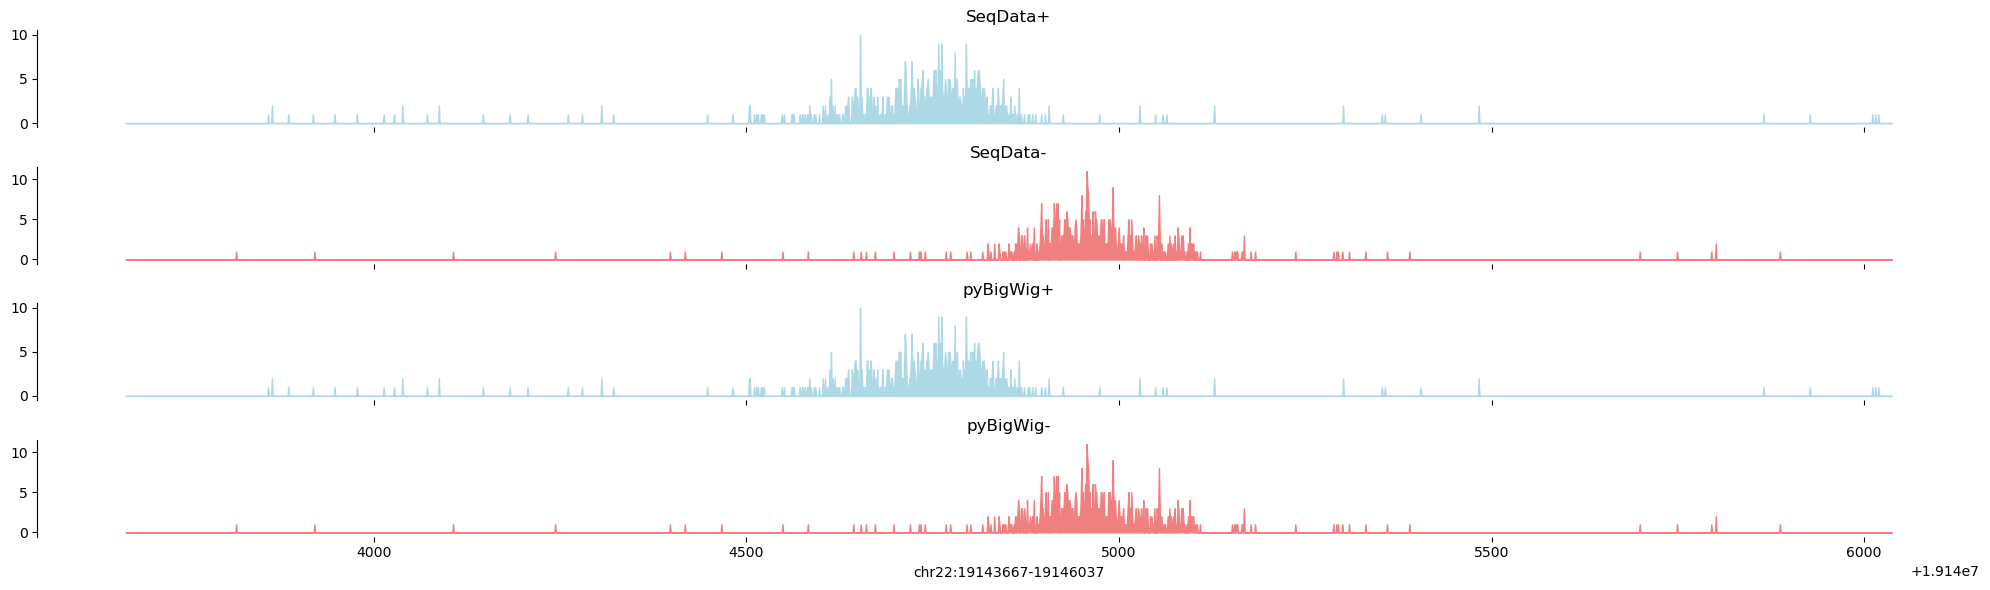

In [20]:
# Plot tracks
plot_tracks({
    "SeqData+": sdata_plus_vals,
    "SeqData-": sdata_minus_vals,
    "pyBigWig+": pybw_plus_vals,
    "pyBigWig-": pybw_minus_vals
    }, 
    interval,
    colors={
        "SeqData+": "lightblue",
        "SeqData-": "lightcoral",
        "pyBigWig+": "lightblue",
        "pyBigWig-": "lightcoral",

    }
)

# DONE!

---